In [1]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

In [3]:
bcf_mordred_full = pd.read_csv('data/featureset/labeled/bcf_mordred_full.csv', index_col=0)
bcf_mordred_partial = pd.read_csv('data/featureset/labeled/bcf_mordred_partial.csv', index_col=0)
bcf_ecfp4_1024 = pd.read_csv('data/featureset/labeled/bcf_ecfp4_1024.csv', index_col=0)
bcf_ecfp4_2048 = pd.read_csv('data/featureset/labeled/bcf_ecfp4_2048.csv', index_col=0)
bcf_ecfp4_4096 = pd.read_csv('data/featureset/labeled/bcf_ecfp4_4096.csv', index_col=0)

# use unlabeled PFAS as bigger cluster for sampling - only works for ECFP4 or graph
unlabeled_ecfp4_1024 = pd.read_csv('data/featureset/unlabeled/bcf_ecfp4_1024.csv', index_col=0)
unlabeled_ecfp4_2048 = pd.read_csv('data/featureset/unlabeled/bcf_ecfp4_2048.csv', index_col=0)
unlabeled_ecfp4_4096 = pd.read_csv('data/featureset/unlabeled/bcf_ecfp4_4096.csv', index_col=0)

In [3]:
# data into matrix
# y is array used for finding indices of PFAS labels
def get_arrays(dataframe, scale=True):
    featureset = dataframe.drop(columns=['logBCF', 'cSMILES'], axis=1)
    
    labels = featureset.pop('Category').to_numpy()
    X = featureset.to_numpy()
    
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
    return X, labels

# helper function for concatenating and processing ECFP4 dataframe with unlabeled PFAS
def get_arrays_unlabeled(dataframe, unlabeled, scale=True):
    labeled = dataframe.drop(columns=['logBCF', 'cSMILES'], axis=1)
    unlabeled['Category'] = 3
    
    featureset = pd.concat([labeled, unlabeled], ignore_index=True)
    labels = featureset.pop('Category').to_numpy()
    X = featureset.to_numpy()
    
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
    return X, labels

In [4]:
# Calculate euclidean distance from center of PFAS cluster (centroid) in feature space
def centroid(datapoints):
    # calculate mean of all PC values
    # [:, i] indexes the ith column of a 2D np array
    return np.array([np.mean(datapoints[:, i]) for i in range(datapoints.shape[1])])
    
# p1, p2 are array of n values along n axes
def euclidean_distance(p1, p2):
    # make sure dimensions are the same
    if p1.shape != p2.shape:
        print("Incompatible dimensions")
        return None
    
    # square root of squares of the absolute distances for each dimension
    return math.sqrt(sum((abs(p1[i] - p2[i]) ** 2 for i in range(len(p1)))))

# Consider distance to closest point in the cluster instead of distance to centroid
# Calculate smallest euclidean distance to PFAS datapoint
def min_distance(p1, pfas):
    return min([euclidean_distance(p1, i) for i in pfas])

# Return array of smallest distance of each datapoint to any point in pfas cluster
def dist_to_point(datapoints, pfas):
    return np.array([min_distance(i, pfas) for i in datapoints])

# Return array of distance of each datapoint to centroid
def dist_to_centroid(datapoints, centroid):
    return np.array([euclidean_distance(i, centroid) for i in datapoints])
    

*Note that unlabeled PFAS data can only be used alongside ECFP4 data due to the loss of features with Mordred.

# PCA

In [15]:
# PCA function on dataset - can choose number of components
def pca_sampler(dataframe, samples=200, scale=True, use_centroid=True, minvariance=0.01, mintotalvariance=0.5, visualize_2d=False, visualize_3d=False):
    """
    Uses PCA dimensionality reduction and samples training set nearest to PFAS datapoints in feature space.
    minvariance: float
        Minimum percentage variance explained by included components. Can use 0 if want to include all.
    mintotalvariance: float
        Use as many components as possible until reaching this cumulative explained variance.
    """
    
    X, labels = get_arrays(dataframe, scale=scale)
    
    # keep all components first!
    pca = PCA()
    pca.fit(X)
    
    # print all relevant components based on minvariance
    relevant_variance = pca.explained_variance_ratio_[pca.explained_variance_ratio_ >= minvariance]
    print("Explained variance of relevant components:")
    print(relevant_variance)
    
    # keep adding components until stoppers hit
    totalvariance = 0
    components = 0
    for v in pca.explained_variance_ratio_:
        if totalvariance > mintotalvariance:
            break
        elif v < minvariance:
            print("Process stopped as components are no longer significant.")
            break
        totalvariance += v
        components += 1
        
    print("Total components used:", components)    
    X_pca = pca.transform(X)[:, :components]
    
    # sampling methodology
    if use_centroid:
        pfas_centroid = centroid(X_pca[labels == 2])
        distance_arr = dist_to_centroid(X_pca, pfas_centroid) # (1215,)
        
        # calculate distance needed for 200 samples by ordering array smallest to largest w/o pfas!
        # sort from smallest to largest (no labels == 2), take the value of 200th largest as distance
        distance = np.sort(distance_arr[labels != 2])[samples - 1]
        
        mask = np.logical_and(labels != 2, distance_arr <= distance)
        labels[mask] = 1
        print('PCA Targets Sampled:', labels[mask].shape[0])
    else:
        index_matrix = (labels < 2).nonzero()[0]
        distance_arr = dist_to_point(X_pca[labels < 2], X_pca[labels == 2])
        distance = np.sort(distance_arr)[samples - 1]

        mask = index_matrix[distance_arr <= distance]
        labels[mask] = 1
        print('PCA Targets Sampled:', labels[mask].shape[0])
    
    # make graph of general, target, pfas clusters? (optional)
    if visualize_2d:
        # make graph
        label_names = ['non-PFAS', 'target', 'PFAS']
        colors = ["navy", "lightcoral", "lightskyblue"]
        for color, i, label_name in zip(colors, [0, 1, 2], label_names):
            plt.scatter(
                X_pca[labels == i, 0], X_pca[labels == i, 1], color=color, alpha=0.8, label=label_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("PCA Sampling Results")
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if visualize_3d:
        # make graph
        fig = plt.figure(1, figsize=(8, 8), dpi=100) #, figsize=(18.5, 10.5)
        ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
        ax.set_position([0, 0, 0.95, 1])

        # place labels for the clusters
        for name, label in [("non-PFAS", 0), ("target", 1), ("PFAS", 2)]:
            ax.text3D(
                X_pca[labels == label, 0].mean(),
                X_pca[labels == label, 1].mean(),
                X_pca[labels == label, 2].mean(),
                name,
                horizontalalignment="center",
                bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
            )
        ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap=plt.get_cmap('plasma'), edgecolor="k")

        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_title('PCA Sampling Results')
    
    # return dataset with targets labeled 1 in Category
    dataframe['Category'] = labels.tolist()
    return dataframe.drop(columns=['cSMILES'])

In [56]:
def pca_semi_sampler(dataframe, unlabeled, samples=200, scale=True, use_centroid=True, minvariance=0.01, mintotalvariance=0.5, visualize_2d=False, visualize_3d=False):
    """PCA clustering and sampling training set using unlabeled PFAS datapoints (3 = unlabeled pfas)."""
    X, labels = get_arrays_unlabeled(dataframe, unlabeled, scale=scale)

    # keep all components first!
    pca = PCA()
    pca.fit(X)
    
    # print all relevant components based on minvariance
    relevant_variance = pca.explained_variance_ratio_[pca.explained_variance_ratio_ >= minvariance]
    print("Explained variance of relevant components:")
    print(relevant_variance)
    
    # keep adding components until stoppers hit
    totalvariance = 0
    components = 0
    for v in pca.explained_variance_ratio_:
        if totalvariance > mintotalvariance:
            break
        elif v < minvariance:
            print("Process stopped as components are no longer significant.")
            break
        totalvariance += v
        components += 1
        
    print("Total components used:", components)    
    X_pca = pca.transform(X)[:, :components]
    
    # sampling methodology
    if use_centroid:
        pfas_centroid = centroid(X_pca[np.logical_or(labels == 2, labels == 3)])
        distance_arr = dist_to_centroid(X_pca, pfas_centroid) # (1215,)
        
        # calculate distance needed for 200 samples by ordering array smallest to largest w/o pfas!
        # sort from smallest to largest (no labels == 2), take the value of 200th largest as distance
        distance = np.sort(distance_arr[np.logical_and(labels != 2, labels != 3)])[samples - 1]
        
        mask = np.logical_and.reduce((labels != 2, labels != 3, distance_arr <= distance))
        labels[mask] = 1
        print('PCA Targets Sampled:', labels[mask].shape[0])
    else:
        index_matrix = (labels < 2).nonzero()[0]
        distance_arr = dist_to_point(X_pca[labels < 2], X_pca[np.logical_or(labels == 2, labels == 3)])
        distance = np.sort(distance_arr)[samples - 1]

        mask = index_matrix[distance_arr <= distance]
        labels[mask] = 1
        print('PCA Targets Sampled:', labels[mask].shape[0])
    
    # make graph of general, target, pfas clusters? (optional)
    if visualize_2d:
        # make graph
        label_names = ['non-PFAS', 'target', 'PFAS', 'unlabeled-PFAS']
        colors = ["navy", "lightcoral", "lightskyblue", "mediumpurple"]
        for color, i, label_name in zip(colors, [0, 1, 2, 3], label_names):
            plt.scatter(
                X_pca[labels == i, 0], X_pca[labels == i, 1], color=color, alpha=0.8, label=label_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("PCA Sampling Results")
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if visualize_3d:
        # make graph
        fig = plt.figure(1, figsize=(8, 8), dpi=100) #, figsize=(18.5, 10.5)
        ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
        ax.set_position([0, 0, 0.95, 1])

        # place labels for the clusters
        for name, label in [("non-PFAS", 0), ("target", 1), ("PFAS", 2), ("unlabeled-PFAS", 3)]:
            ax.text3D(
                X_pca[labels == label, 0].mean(),
                X_pca[labels == label, 1].mean(),
                X_pca[labels == label, 2].mean(),
                name,
                horizontalalignment="center",
                bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
            )
        ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap=plt.get_cmap('plasma'), edgecolor="k")

        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_title('PCA Sampling Results')
    
    # remove unlabeled pfas
    labels = labels[labels != 3]
    dataframe['Category'] = labels.tolist()
    return dataframe.drop(columns=['cSMILES'])

Explained Variance Ratio:
[0.26256129 0.07333612 0.05834526]
PCA Targets Sampled: 200


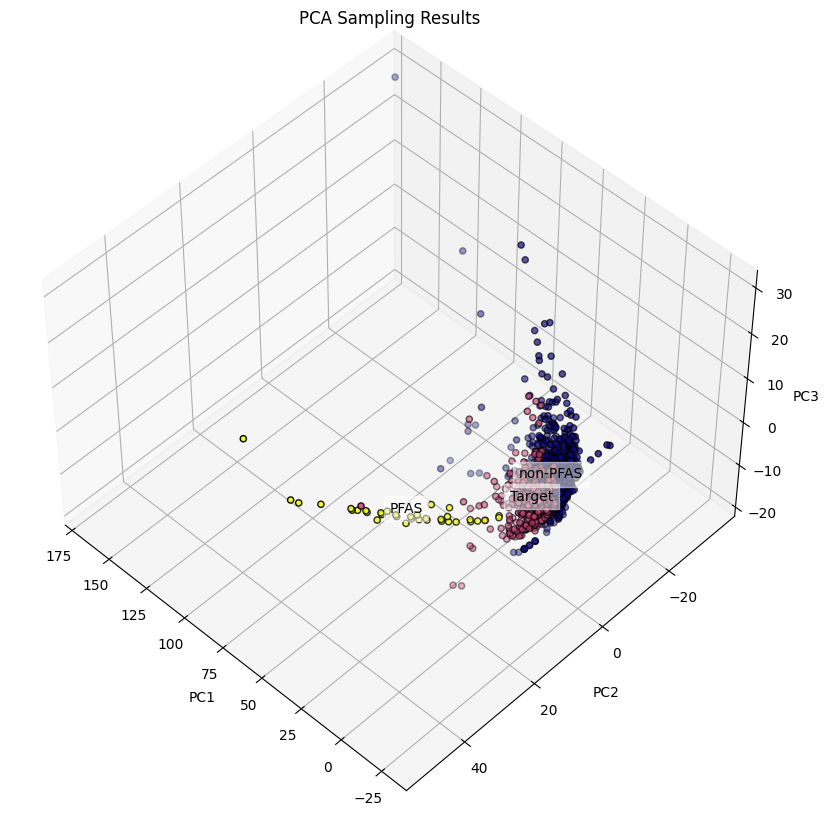

In [46]:
%matplotlib inline
bcf_mordred_full_pca = pca_sampler(bcf_mordred_full, use_centroid=False)
bcf_mordred_full_pca.to_csv('data/targetset/bcf_mordred_full_pca.csv')

Explained Variance Ratio:
[0.01414464 0.01026724 0.00813632]
PCA Targets Sampled: 200


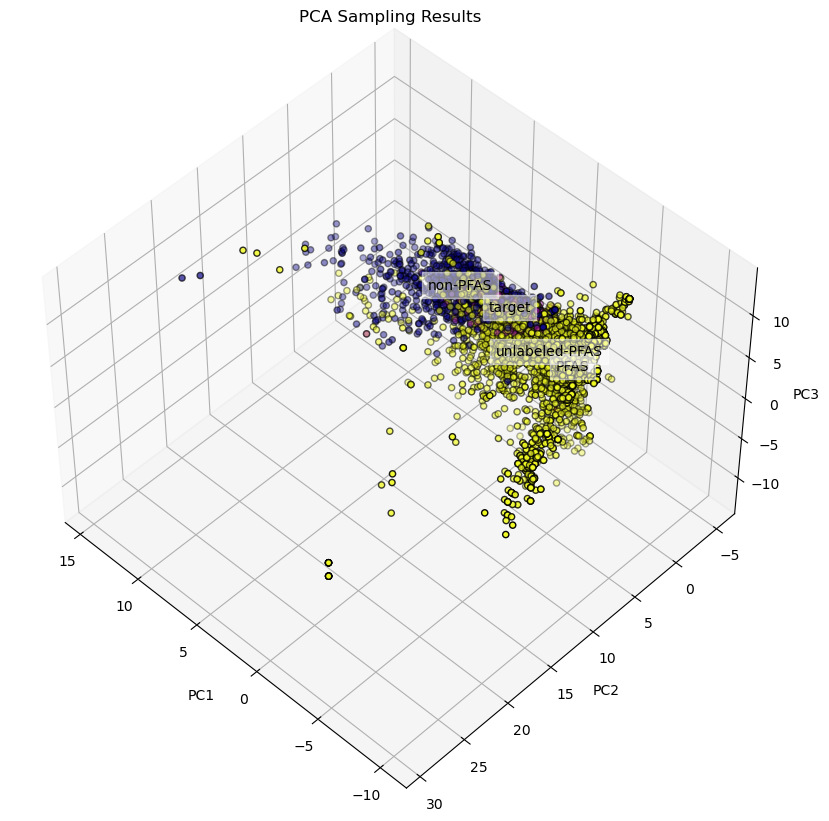

In [57]:
%matplotlib inline
bcf_ecfp4_1024_pca = pca_semi_sampler(bcf_ecfp4_1024, unlabeled_ecfp4_1024, scale=False, use_centroid=False)
bcf_ecfp4_1024_pca.to_csv('data/targetset/bcf_ecfp4_1024_pca.csv')

# UMAP

In [14]:
def umap_sampler(dataframe, n_neighbors=15, n_components=2, samples=200, scale=True, use_centroid=True):
    """Uses UMAP dimensionality reduction and samples training set nearest to PFAS datapoints in feature space."""
    X, labels = get_arrays(dataframe, scale=scale)

    # copy and transform dataset
    # separate pfas and nonpfas
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components)
    X_umap = reducer.fit_transform(X)
    
    # sampling methodology
    if use_centroid:
        pfas_centroid = centroid(X_umap[labels == 2])
        distance_arr = dist_to_centroid(X_umap, pfas_centroid) # (1215,)
        
        # calculate distance needed for 200 samples by ordering array smallest to largest w/o pfas!
        # sort from smallest to largest (no labels == 2), take the value of 200th largest as distance
        distance = np.sort(distance_arr[labels != 2])[samples - 1]
        
        mask = np.logical_and(labels != 2, distance_arr <= distance)
        labels[mask] = 1
        print('UMAP Targets Sampled:', labels[mask].shape[0])
    else:
        index_matrix = (labels < 2).nonzero()[0]
        distance_arr = dist_to_point(X_umap[labels < 2], X_umap[labels == 2])
        distance = np.sort(distance_arr)[samples - 1]

        mask = index_matrix[distance_arr <= distance]
        labels[mask] = 1
        
        # distance_arr = dist_to_point(X_umap, X_umap[labels == 2])
        # distance = np.sort(distance_arr[labels != 2])[samples - 1]
        
        # mask = np.logical_and(labels != 2, distance_arr <= distance)
        # labels[mask] = 1
        print('UMAP Targets Sampled:', labels[mask].shape[0])
    
    # make graph of general, target, pfas clusters? (optional)
    if n_components == 2:
        # make graph
        label_names = ['non-PFAS', 'target', 'PFAS']
        colors = ["navy", "lightcoral", "lightskyblue"]
        for color, i, label_name in zip(colors, [0, 1, 2], label_names):
            plt.scatter(
                X_umap[labels == i, 0], X_umap[labels == i, 1], color=color, alpha=0.8, label=label_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("UMAP Sampling Results")
    
    if n_components == 3:
        # make graph
        fig = plt.figure(1, figsize=(8, 8), dpi=100) #, figsize=(18.5, 10.5)
        ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
        ax.set_position([0, 0, 0.95, 1])

        # place labels for the clusters
        for name, label in [("non-PFAS", 0), ("target", 1), ("PFAS", 2)]:
            ax.text3D(
                X_umap[labels == label, 0].mean(),
                X_umap[labels == label, 1].mean(),
                X_umap[labels == label, 2].mean(),
                name,
                horizontalalignment="center",
                bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
            )
        ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=labels, cmap=plt.get_cmap('plasma'), edgecolor="k")

        ax.set_title('UMAP Sampling Results')
    
    # return dataset with targets labeled 1 in Category
    # remember to drop cSMILES of original dataframe before returning for export
    dataframe['Category'] = labels.tolist()
    return dataframe.drop(columns=['cSMILES'])

In [33]:
def umap_semi_sampler(dataframe, unlabeled, n_neighbors=15, n_components=2, samples=200, scale=True, use_centroid=True):
    """UMAP clustering and sampling training set using unlabeled PFAS datapoints (3 = unlabeled pfas)."""
    X, labels = get_arrays_unlabeled(dataframe, unlabeled, scale=scale)

    # copy and transform dataset
    # separate pfas and nonpfas
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components)
    X_umap = reducer.fit_transform(X)
    
    # sampling methodology
    if use_centroid:
        pfas_centroid = centroid(X_umap[np.logical_or(labels == 2, labels == 3)])
        distance_arr = dist_to_centroid(X_umap, pfas_centroid) # (1215,)
        
        # calculate distance needed for 200 samples by ordering array smallest to largest w/o pfas!
        # sort from smallest to largest (no labels == 2), take the value of 200th largest as distance
        distance = np.sort(distance_arr[np.logical_and(labels != 2, labels != 3)])[samples - 1]
        
        mask = np.logical_and.reduce((labels != 2, labels != 3, distance_arr <= distance))
        labels[mask] = 1
        print('UMAP Targets Sampled:', labels[mask].shape[0])
    else:
        index_matrix = (labels < 2).nonzero()[0]
        distance_arr = dist_to_point(X_umap[labels < 2], X_umap[np.logical_or(labels == 2, labels == 3)])
        distance = np.sort(distance_arr)[samples - 1]

        mask = index_matrix[distance_arr <= distance]
        labels[mask] = 1
        
        # distance_arr = dist_to_point(X_umap, X_umap[np.logical_or(labels == 2, labels == 3)])
        # distance = np.sort(distance_arr[np.logical_and(labels != 2, labels != 3)])[samples - 1]
        
        # mask = np.logical_and.reduce((labels != 2, labels != 3, distance_arr <= distance))
        # labels[mask] = 1
        print('UMAP Targets Sampled:', labels[mask].shape[0])
    
    # make graph of general, target, pfas clusters? (optional)
    if n_components == 2:
        # make graph
        label_names = ['non-PFAS', 'target', 'PFAS', 'unlabeled-PFAS']
        colors = ["navy", "lightcoral", "lightskyblue", "mediumpurple"]
        for color, i, label_name in zip(colors, [0, 1, 2, 3], label_names):
            plt.scatter(
                X_umap[labels == i, 0], X_umap[labels == i, 1], color=color, alpha=0.8, label=label_name
            )
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        plt.title("UMAP Sampling Results")
    
    if n_components == 3:
        # make graph
        fig = plt.figure(1, figsize=(8, 8), dpi=100) #, figsize=(18.5, 10.5)
        ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
        ax.set_position([0, 0, 0.95, 1])

        # place labels for the clusters
        for name, label in [("non-PFAS", 0), ("target", 1), ("PFAS", 2), ("unlabeled-PFAS", 3)]:
            ax.text3D(
                X_umap[labels == label, 0].mean(),
                X_umap[labels == label, 1].mean(),
                X_umap[labels == label, 2].mean(),
                name,
                horizontalalignment="center",
                bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
            )
        ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=labels, cmap=plt.get_cmap('plasma'), edgecolor="k")

        ax.set_title('UMAP Sampling Results')
    
    # remove unlabeled pfas
    labels = labels[labels != 3]
    dataframe['Category'] = labels.tolist()
    return dataframe.drop(columns=['cSMILES'])

UMAP Targets Sampled: 200


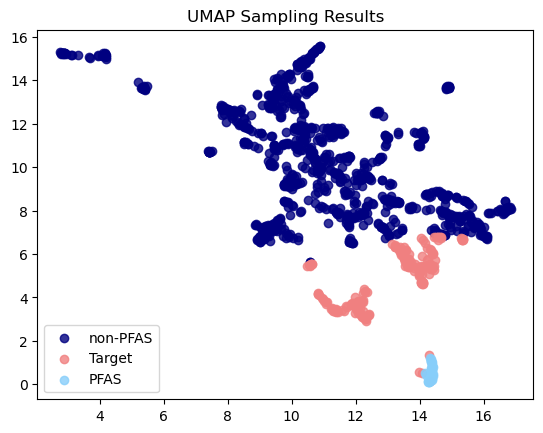

In [15]:
bcf_mordred_full_umap = umap_sampler(bcf_mordred_full)

# Polar Compounds

### Manual Search Using Extracted Labels:

In [141]:
def canonicalize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    else:
        return Chem.MolToSmiles(mol)

# generate csmiles, remove duplicates
bcfexpanded = pd.read_excel('Expanded_BCF.xlsx')
bcfexpanded['cSMILES'] = bcfexpanded.SMILES.apply(canonicalize)
bcfexpanded.drop_duplicates(subset=['cSMILES'], inplace=True, ignore_index=True)

# use regex to search names for keywords
# use filtered polar compounds to then filter out polar compounds from general dataset for transfer learning
regex_manual = 'alcohol|phenol|ketone|surfactant|aldehyde|acid|amine|nitro|amide|ester|ether|furan|lactone|ethanol'
polarset = bcfexpanded[bcfexpanded['Substance Name'].str.contains(regex_manual, flags=re.IGNORECASE)]

print('Manual polar compound target set:', len(polarset))

Manual polar compound target set: 246


In [142]:
# for manual polar selection give entire dataframe
def manual_polar_sel(dataframe):
    # if cSMILES matches any in polarset, then let Category = 1
    dataframe.loc[dataframe.cSMILES.isin(polarset['cSMILES']), 'Category'] = 1
    
    # drop cSMILES columns
    return dataframe.drop(columns=['cSMILES'])

In [143]:
bcf_mordred_full_polar = manual_polar_sel(bcf_mordred_full)
bcf_mordred_full_polar.to_csv('data/targetset/bcf_mordred_full_manual_polar.csv')

### Using Classyfire:

In [8]:
# automated polar selection via classyfire
# first export tsv file of SMILES representations
# then submit to classyfire via web server
regex_auto = 'alcohol|phenol|ketone|surfactant|aldehyde|carboxylic acid|sulfonic acid|amine|nitro|amide|azo|ester|ether|furan|lactone'

def export_smiles(dataframe, filename):
    # save as tsv
    export = dataframe[dataframe['Category'] == 0]
    export['cSMILES'].to_csv('classyfire/query/{}.tsv'.format(filename), sep="\t", header=False)

# process query results here
def classyfire_sel(dataframe, filename, min_match=1):
    copy = dataframe.copy()
    results = pd.read_csv('classyfire/retrieval/{}.csv'.format(filename))
    results['ClassifiedResults'] = results['ClassifiedResults'].astype(str) # convert to str for regex search
    
    # for each category == 0, look at corresponding index in results['CompoundID']
    indices = copy.index[copy['Category'] == 0].tolist()
    targets = 0
    for i in indices:
        classification = results[results['CompoundID'] == i]
        
        # do regex search on ClassifiedResults
        # if True, then set category = 1
        count = classification['ClassifiedResults'].str.contains(regex_auto, flags = re.IGNORECASE).sum()
        if count >= min_match:
            copy.at[i, 'Category'] = 1
            targets += 1
    
    print('Classyfire polar compound target set:', targets)
    return copy.drop(columns=['cSMILES'])

In [62]:
export_smiles(bcf_mordred_full, 'bcf_mordred_full')

In [9]:
bcf_mordred_full_classy = classyfire_sel(bcf_mordred_full, 'bcf_mordred_full', min_match=5)
bcf_mordred_full_classy.to_csv('data/targetset/bcf_mordred_full_classy_5.csv')

Classyfire polar compound target set: 667
